In [1]:
# from pyquant.SVI import SVICalc
from importlib import reload
import pyquant.svi
reload(pyquant.svi)

from pyquant.svi import *
from pyquant.common import *
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd

import itertools
from scipy.stats import norm
import matplotlib.pyplot as plt
# plt.style.use("dark_background")
pd.set_option('display.max_columns', 1000)
%matplotlib inline

In [2]:
bs_calc = BSCalc()

strikes = np.array([1300., 1400, 1500, 1600, 1700, 1800., 1900, 2000, 2100, 2200])
call_strikes = np.array([1800., 1900, 2000, 2100, 2200])
tau = 0.01
F = 1723.75
pvs = np.array([ 1.72375, 1.72375, 3.4475, 6.895, 26.718125, 11.204375,
                4.309375, 1.72375, 0.861875, 0.861875])

implied_vols = bs_calc.implied_vols(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)), 
    Strikes(strikes),
    Premiums(pvs)
).data

vol_smile_chain = VolSmileChain(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(implied_vols)
)
weights = CalibrationWeights(np.ones_like(vol_smile_chain.Ks))



In [3]:
svi_calc = SVICalc()

In [4]:
calibrated_params = svi_calc.calibrate(vol_smile_chain, weights)

/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:403: RuntimeWarning: invalid value encountered in sqrt
  denominator = 2 * np.sqrt(T * w)
/Users/zugzvangg/Desktop/Projects/noa/docs/quant/pyquant/svi.py:370: RuntimeWarning: invalid value encountered in sqrt
  iv = np.sqrt(w / T)


In [5]:
calibrated_params.array()

array([-0.05516348,  0.19508255, -0.53059706, -0.22331506,  0.35125428])

In [6]:
svi_calc.calibration_error

1.4068043478413755e-05

In [7]:
svi_calc.raw_cached_params

array([-0.05516348,  0.19508255, -0.53059706, -0.22331506,  0.35125428])

In [8]:
svi_calc.jump_wing_cached_params

array([0.292075  , 0.0106822 , 5.52499778, 1.69440429, 0.29187617])

In [9]:
test_strikes = Strikes(np.linspace(strikes[0], strikes[-1], 100))

In [10]:
test_iv = svi_calc.implied_vols(
    Forward(Spot(F), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    calibrated_params
)

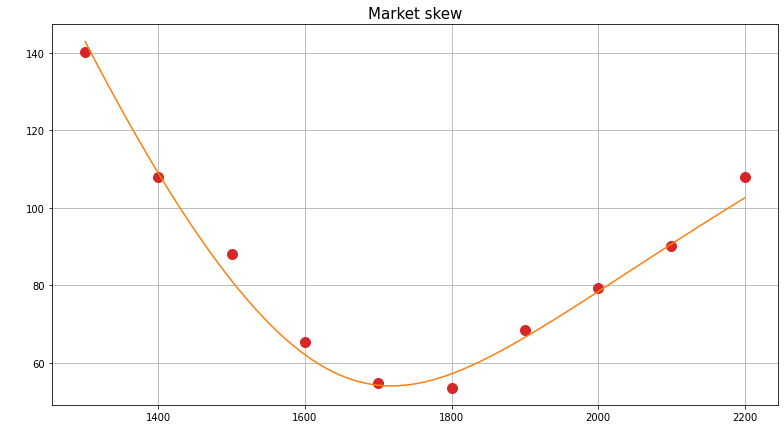

In [11]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

#### Warm starting

In [12]:
new_forward = 1723.25
new_pvs = np.array([ 0.861625,  1.72325 ,  3.4465  ,  6.893   , 26.710375,
                    11.201125,  4.308125,  1.72325 ,  1.72325 ,  0.861625])

In [13]:
new_implied_vols = bs_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    Premiums(new_pvs)
).data

In [14]:
new_vol_smile_chain = VolSmileChain(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(new_implied_vols)
)

In [15]:
svi_calc.cached_params = calibrated_params.array()

In [16]:
new_calibrated_params = svi_calc.calibrate(new_vol_smile_chain,  weights)
print(svi_calc.calibration_error)
new_calibrated_params.array()

6.0128917261860604e-06


array([-0.01094361,  0.08051245, -0.00554534,  0.01066677,  0.172677  ])

#### BSM limit

In [17]:
flat_implied_vols = np.ones_like(implied_vols)*0.8
flat_vol_smile_chain = VolSmileChain(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(flat_implied_vols)
)
svi_calc.update_raw_cached_params(
    SVIRawParams(A(1.0), B(1.0), Rho(0.0), M(1.0), Sigma(1.0))
)
flat_calibrated_params = svi_calc.calibrate(flat_vol_smile_chain,  weights)
print(svi_calc.calibration_error)
flat_calibrated_params.array()

9.900607893905262e-09


array([ 0.00410207,  0.00166228, -0.15346144, -0.23384131,  1.3887245 ])

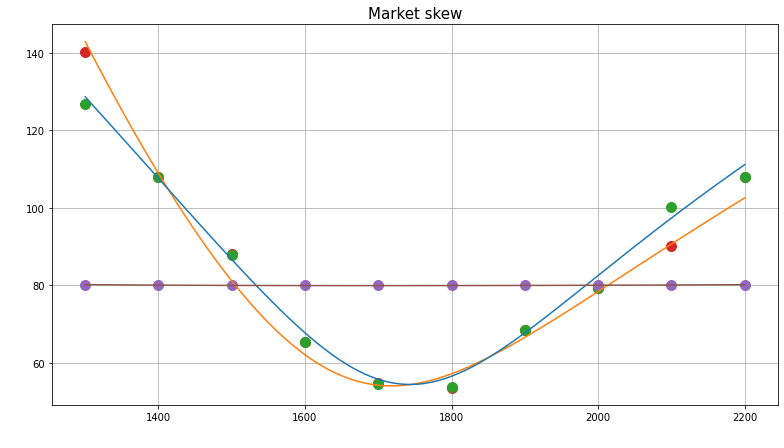

In [18]:
flat_test_iv = svi_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    flat_calibrated_params
)
new_test_iv = svi_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    new_calibrated_params
)
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(strikes, 100*new_implied_vols, '.C2', markersize=20)
plt.plot(strikes, 100*flat_implied_vols, '.C4', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.plot(test_strikes.data, 100*new_test_iv.data, 'C0')
plt.plot(test_strikes.data, 100*flat_test_iv.data, 'C5')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

#### Greeks and Pricing tests

In [19]:
tenors = {
    'ON' : 1/365,
    '1W' : 7/365,
    '2W' : 14/365,
    '1M' : 1/12,
    '3M' : 1/4,
    '6M' : 1/2,
    '1Y' : 1.,
    '2Y' : 2.,
    '5Y' : 5.
}